# Model Development and Training Notebook

# 1.0 Import Required Packages

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_curve,
    auc
)

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# 2.0 Read the Preprocessed Dataset

In [3]:
df = pd.read_csv("../datasets/df_preprocessed.csv")
df.head()

,age_at_diagnosis,cellularity,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,75.65,2,0,1.0,3.0,1,10.0,5.0,6.044,140.500000,...,0,0,0,0,0,1,0,1,0,1
1,43.19,2,0,1.0,3.0,1,0.0,2.0,4.020,84.633333,...,0,0,0,0,0,1,0,1,0,1
2,48.87,2,1,1.0,2.0,1,1.0,2.0,4.030,163.700000,...,0,0,0,0,0,1,0,1,0,1
3,47.68,1,1,1.0,2.0,1,3.0,1.0,4.050,164.933333,...,0,0,0,0,0,1,0,1,0,1
4,76.97,2,1,1.0,3.0,1,8.0,2.0,6.080,41.366667,...,0,0,0,0,0,1,0,1,0,1


# 3.0 Drop the `death_from_cancer` column
The reason is this column is considered as a **data leakage** source. it tells us information about the target variable, which can lead to a misleading performance.

In [4]:
df.drop(columns="death_from_cancer", inplace=True)
df.head()

,age_at_diagnosis,cellularity,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,75.65,2,0,1.0,3.0,1,10.0,5.0,6.044,140.500000,...,0,0,0,0,0,1,0,1,0,1
1,43.19,2,0,1.0,3.0,1,0.0,2.0,4.020,84.633333,...,0,0,0,0,0,1,0,1,0,1
2,48.87,2,1,1.0,2.0,1,1.0,2.0,4.030,163.700000,...,0,0,0,0,0,1,0,1,0,1
3,47.68,1,1,1.0,2.0,1,3.0,1.0,4.050,164.933333,...,0,0,0,0,0,1,0,1,0,1
4,76.97,2,1,1.0,3.0,1,8.0,2.0,6.080,41.366667,...,0,0,0,0,0,1,0,1,0,1


# 4.0 Model Development

## 4.1 Preparing the Dataset

### 4.1.1 Splitting the Features from the Target

In [5]:
X = df.drop(columns="overall_survival")
y = df["overall_survival"]

X

,age_at_diagnosis,cellularity,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,75.65,2,0,1.0,3.0,1,10.0,5.0,6.044,140.500000,...,0,0,0,0,0,1,0,1,0,1
1,43.19,2,0,1.0,3.0,1,0.0,2.0,4.020,84.633333,...,0,0,0,0,0,1,0,1,0,1
2,48.87,2,1,1.0,2.0,1,1.0,2.0,4.030,163.700000,...,0,0,0,0,0,1,0,1,0,1
3,47.68,1,1,1.0,2.0,1,3.0,1.0,4.050,164.933333,...,0,0,0,0,0,1,0,1,0,1
4,76.97,2,1,1.0,3.0,1,8.0,2.0,6.080,41.366667,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,43.10,2,0,4.0,3.0,1,1.0,4.0,5.050,196.866667,...,0,0,0,0,0,0,0,0,0,0
1900,42.88,2,0,4.0,3.0,0,1.0,6.0,5.040,44.733333,...,0,0,0,0,0,0,0,0,0,0
1901,62.90,2,0,4.0,3.0,1,45.0,4.0,6.050,175.966667,...,0,0,0,0,0,0,0,0,0,0
1902,61.16,1,0,4.0,2.0,1,12.0,15.0,5.050,86.233333,...,0,0,0,0,0,0,0,0,0,0


### 4.1.2 Splitting the Data To Training and Testing Splits

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
X_train.shape, X_test.shape

((1523, 716), (381, 716))

## 4.2 Write Reusable Functions

### 4.2.1 The `plot_metrics_curves` function

In [8]:
def plot_metrics_curves( names, accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores, fit_time_scores,):
    """
    Plot bar charts of various performance metrics for multiple models.

    Parameters:
        - names (list of str): List of model names.
        - accuracy_scores (list of float): List of accuracy scores for the models.
        - precision_scores (list of float): List of precision scores for the models.
        - recall_scores (list of float): List of recall scores for the models.
        - f1_scores (list of float): List of F1 scores for the models.
        - roc_auc_scores (list of float): List of ROC-AUC scores for the models.
        - fit_time_scores (list of float): List of fit time scores for the models.

    Returns:
        - None
    """

    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC", "Fit Time"]
    scores = [
        accuracy_scores,
        precision_scores,
        recall_scores,
        f1_scores,
        roc_auc_scores,
        fit_time_scores,
    ]

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Model Performance Metrics")

    for i, ax in enumerate(axs.flat):
        # Normalize scores to range [0, 1]
        normalized_scores = (scores[i] - np.min(scores[i])) / (
            np.max(scores[i]) - np.min(scores[i])
        )

        # Create a custom color palette based on normalized scores
        custom_palette = sns.color_palette("Blues", n_colors=len(names))
        custom_palette = [
            custom_palette[int(score * (len(custom_palette) - 1))]
            for score in normalized_scores
        ]

        sns.barplot(x=names, y=scores[i], ax=ax, palette=custom_palette, dodge=False)
        ax.set_title(metrics[i])
        ax.set_ylabel("Score" if i != 5 else "Seconds")
        ax.set_ylim(0, 1) if i != 5 else None
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

### 4.2.2 The `train_models` function

In [9]:
def train_models(models, scoring, X, y, cv):
    """
    Train multiple models using cross-validation and evaluate their performance.

    This function trains each model provided in the `models` list using
    cross-validation and evaluates their performance based on various metrics.
    It prints the results and plots bar charts for visual comparison.

    Parameters:
        - models (list of tuple): List of (name, model) tuples where `name` is a string
                                representing the model name and `model` is the model instance.
        - scoring (list of str): List of scoring metrics to evaluate the models.
        - X (array-like): Feature matrix.
        - y (array-like): Target vector.
        - cv (int or cross-validation generator): Determines the cross-validation splitting strategy.

    Returns:
        - tuple: (names, results) where
            names (list of str): List of model names.
            results (list of dict): List of cross-validation results for each model.

    This function also plots the following performance metrics for each model:
        - Accuracy, Precision, Recall, F1 Score, ROC-AUC, Fit Time
    """

    names = []
    results = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    fit_time_scores = []

    for name, model in models:
        result = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        names.append(name)
        results.append(result)

        accuracy_scores.append(result["test_accuracy"].mean())
        precision_scores.append(result["test_precision"].mean())
        recall_scores.append(result["test_recall"].mean())
        f1_scores.append(result["test_f1"].mean())
        roc_auc_scores.append(result["test_roc_auc"].mean())
        fit_time_scores.append(result["fit_time"].sum())

        # Printing the Results
        print(f"Model: {name}")

        print("Results:")
        print(f"Mean Accuracy: {accuracy_scores[-1]:.2f}")
        print(f"Mean Precision: {precision_scores[-1]:.2f}")
        print(f"Mean Recall: {recall_scores[-1]:.2f}")
        print(f"Mean F1 Score: {f1_scores[-1]:.2f}")
        print(f"Mean ROC-AUC Score: {roc_auc_scores[-1]:.2f}")
        print("---------------------------------------")

    # Plotting metrics curves
    plot_metrics_curves( names, accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores, fit_time_scores)

    return names, results

## 4.3 Define the List of Models along with List of Evaluation Metrics

In [10]:
# Define the list of models
models = [
    ("LogisticRegression", LogisticRegression(max_iter=1000)),
    ("DecisionTree", DecisionTreeClassifier(random_state=42, max_depth=10)),
    ("RandomForest", RandomForestClassifier(random_state=42, max_depth=10)),
    ("KNeighbors", KNeighborsClassifier()),
    ("XGBoost", XGBClassifier()),
]

# Define the evaluation metrics
scoring = {
    "accuracy": "accuracy",
    "precision": "precision_macro",
    "recall": "recall_macro",
    "f1": "f1_macro",
    "roc_auc": "roc_auc_ovr",
}

## 4.4 Train and Evaluate the Models

### 4.4.1 Train and Evaluate the Models on all of the Data (716 Features) without Scaling

Model: LogisticRegression
Results:
Mean Accuracy: 0.65
Mean Precision: 0.64
Mean Recall: 0.64
Mean F1 Score: 0.64
Mean ROC-AUC Score: 0.70
---------------------------------------
Model: DecisionTree
Results:
Mean Accuracy: 0.66
Mean Precision: 0.66
Mean Recall: 0.66
Mean F1 Score: 0.66
Mean ROC-AUC Score: 0.62
---------------------------------------
Model: RandomForest
Results:
Mean Accuracy: 0.69
Mean Precision: 0.70
Mean Recall: 0.65
Mean F1 Score: 0.65
Mean ROC-AUC Score: 0.76
---------------------------------------
Model: KNeighbors
Results:
Mean Accuracy: 0.72
Mean Precision: 0.71
Mean Recall: 0.71
Mean F1 Score: 0.71
Mean ROC-AUC Score: 0.77
---------------------------------------
Model: XGBoost
Results:
Mean Accuracy: 0.75
Mean Precision: 0.74
Mean Recall: 0.74
Mean F1 Score: 0.74
Mean ROC-AUC Score: 0.81
---------------------------------------


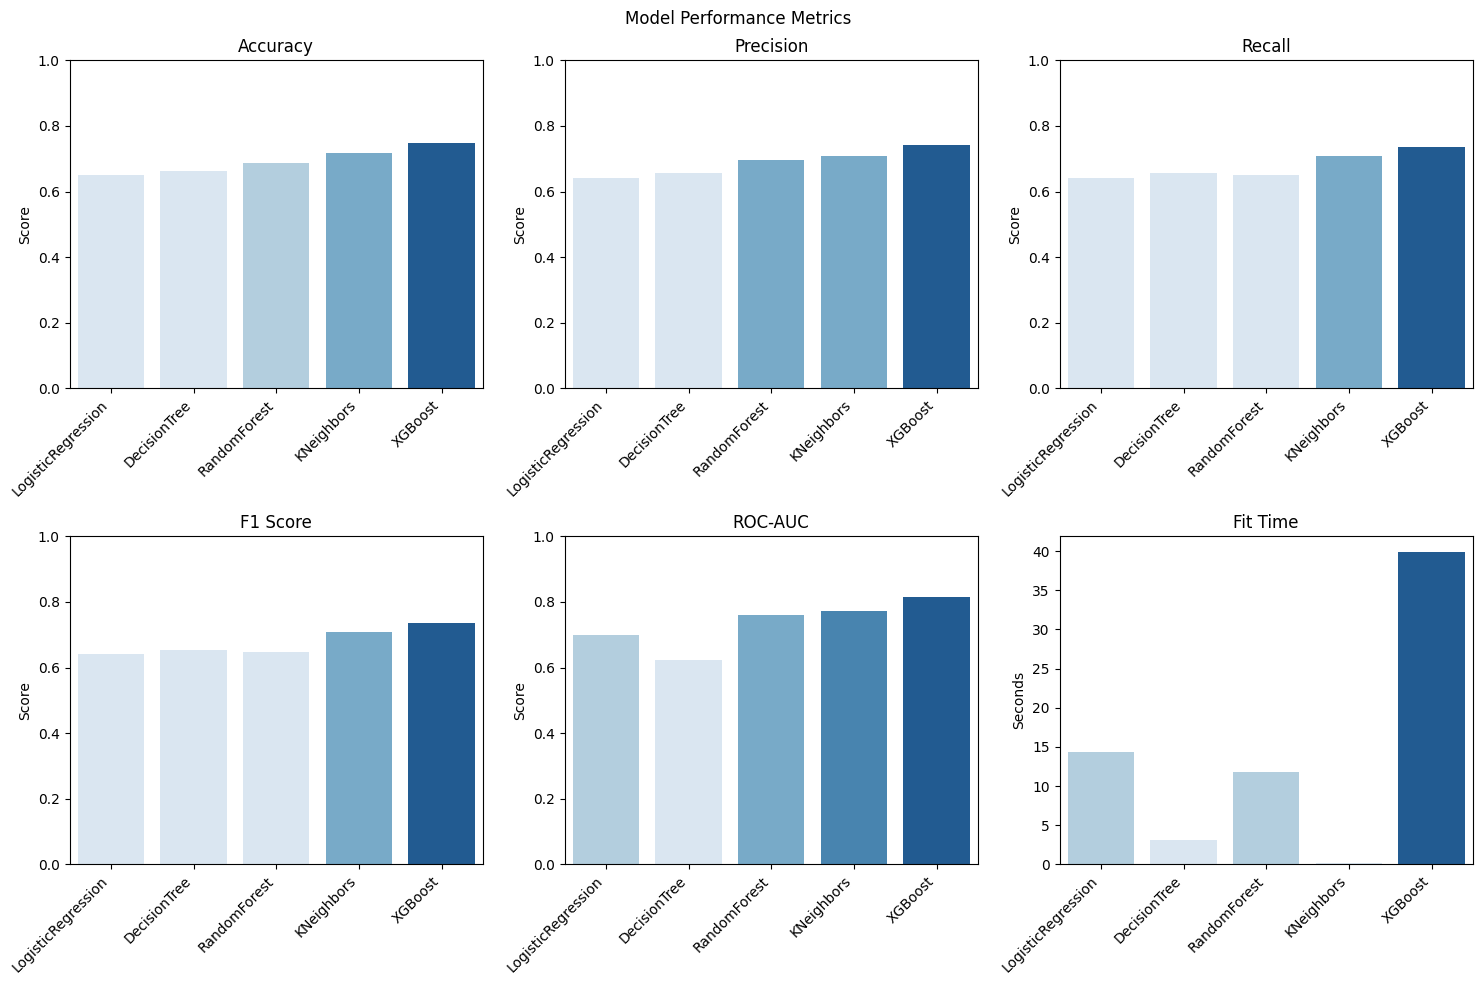

In [11]:
names, results = train_models(models=models, scoring=scoring, X=X_train, y=y_train, cv=5)

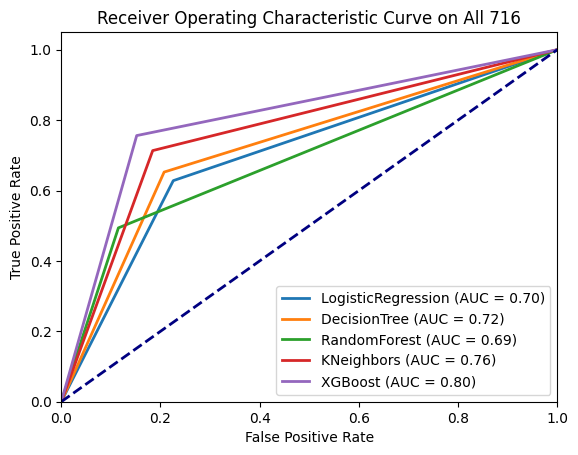

In [12]:
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve on All 716")
plt.legend(loc="lower right")
plt.show()

### 4.4.2 Train and Evaluate the Models on all of the Data (716 Features) without `MinMaxScaler`

In [13]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

Model: LogisticRegression
Results:
Mean Accuracy: 0.72
Mean Precision: 0.71
Mean Recall: 0.70
Mean F1 Score: 0.71
Mean ROC-AUC Score: 0.78
---------------------------------------
Model: DecisionTree
Results:
Mean Accuracy: 0.66
Mean Precision: 0.66
Mean Recall: 0.65
Mean F1 Score: 0.65
Mean ROC-AUC Score: 0.60
---------------------------------------
Model: RandomForest
Results:
Mean Accuracy: 0.70
Mean Precision: 0.71
Mean Recall: 0.67
Mean F1 Score: 0.67
Mean ROC-AUC Score: 0.77
---------------------------------------
Model: KNeighbors
Results:
Mean Accuracy: 0.63
Mean Precision: 0.62
Mean Recall: 0.62
Mean F1 Score: 0.62
Mean ROC-AUC Score: 0.64
---------------------------------------
Model: XGBoost
Results:
Mean Accuracy: 0.76
Mean Precision: 0.75
Mean Recall: 0.75
Mean F1 Score: 0.75
Mean ROC-AUC Score: 0.83
---------------------------------------


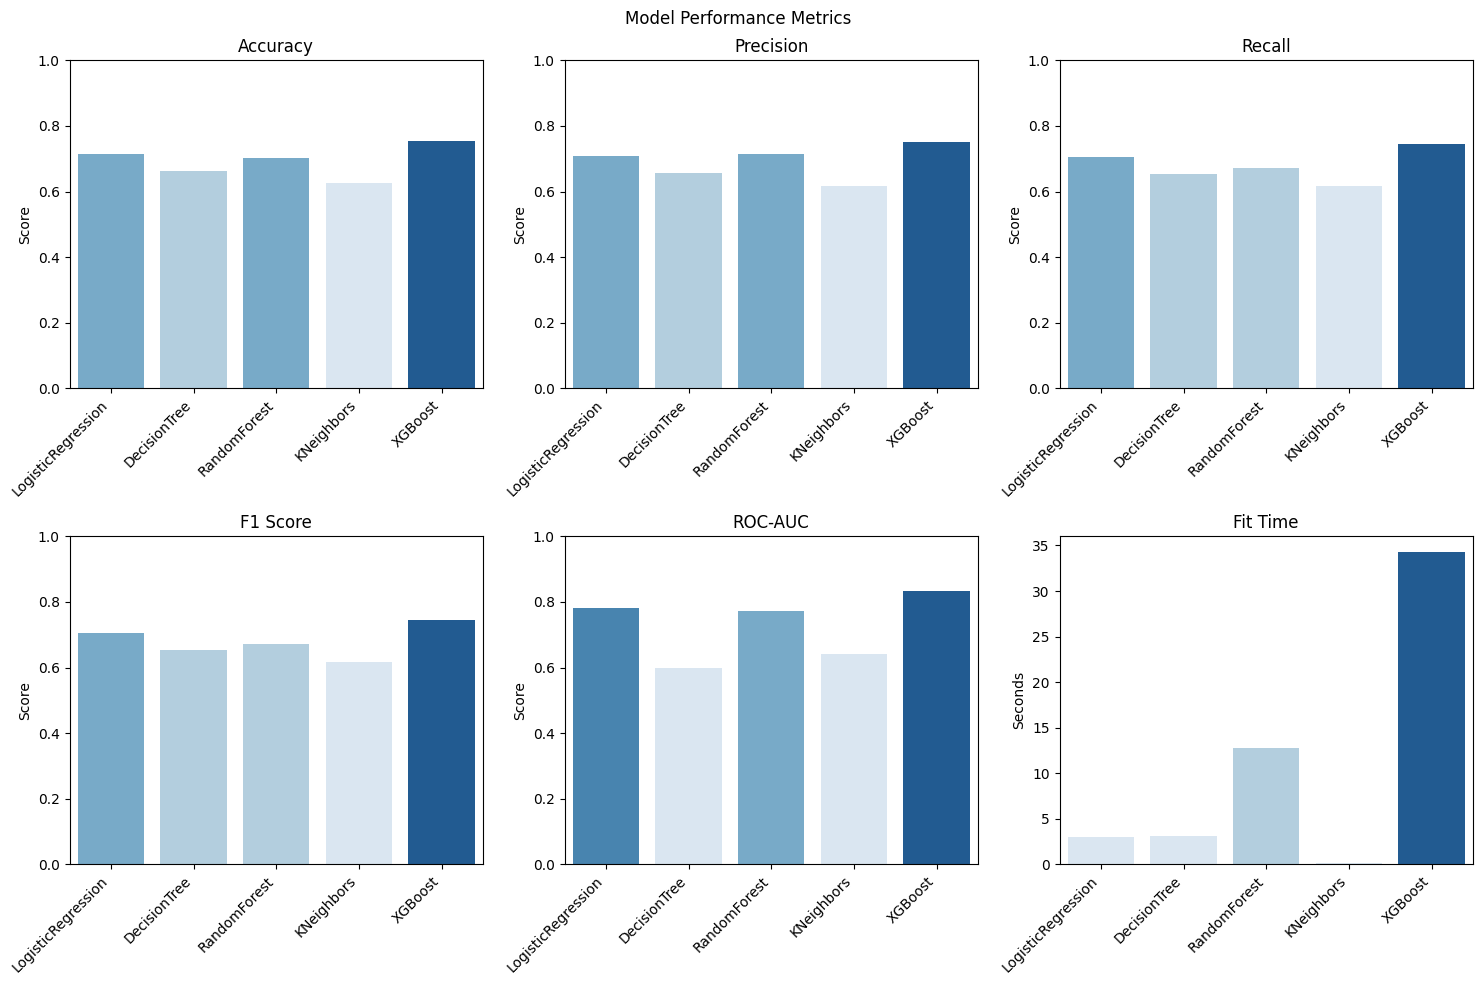

In [14]:
names, results = train_models(models=models, scoring=scoring, X=X_train, y=y_train, cv=5)

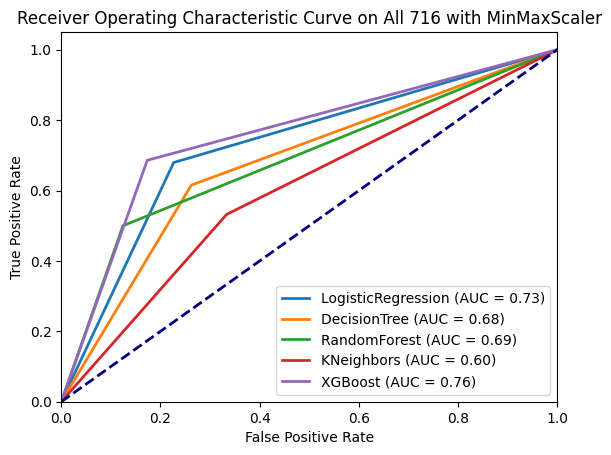

In [15]:
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve on All 716 with MinMaxScaler")
plt.legend(loc="lower right")
plt.show()

In [16]:
results

[{'fit_time': array([0.62197518, 0.60027838, 0.54337001, 0.63759375, 0.62197518]),
  'score_time': array([0.01561856, 0.00602055, 0.        , 0.        , 0.01561856]),
  'test_accuracy': array([0.72459016, 0.70819672, 0.70163934, 0.70065789, 0.74013158]),
  'test_precision': array([0.71819373, 0.70128626, 0.69480207, 0.69419643, 0.73423185]),
  'test_recall': array([0.71271582, 0.69437104, 0.69593464, 0.68498339, 0.73557032]),
  'test_f1': array([0.71462306, 0.69644954, 0.69529801, 0.68722512, 0.73482615]),
  'test_roc_auc': array([0.78748238, 0.77501762, 0.77752819, 0.76110742, 0.80434109])},
 {'fit_time': array([0.62814426, 0.59641576, 0.66371584, 0.62814426, 0.62814426]),
  'score_time': array([0.        , 0.        , 0.00678968, 0.01559329, 0.01559329]),
  'test_accuracy': array([0.68852459, 0.6852459 , 0.6557377 , 0.67105263, 0.61842105]),
  'test_precision': array([0.68081303, 0.67732018, 0.6464534 , 0.6627486 , 0.60892388]),
  'test_recall': array([0.68043076, 0.67655479, 0.6447

In [18]:
from sklearn.model_selection import learning_curve

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_scaled, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 50)
)

# Calculate the mean and standard deviation for the training and testing scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.grid()

# Plot the training scores
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training accuracy")

# Plot the validation scores
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation accuracy"
)

plt.legend(loc="best")
plt.show()

### 4.4.3 Identify Important Features

In [49]:
feature_importances_xgb = models[-1][1].feature_importances_
feature_names = X.columns

feature_importance_df_xgb = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importances_xgb}
)

feature_importance_df_xgb = feature_importance_df_xgb.sort_values("importance", ascending=False)
feature_importance_df_xgb.head()

,feature,importance
432,nras,0.018677
701,rasgef1b_mut,0.018031
211,erbb3,0.011763
8,nottingham_prognostic_index,0.011308
514,hsd17b8,0.010858


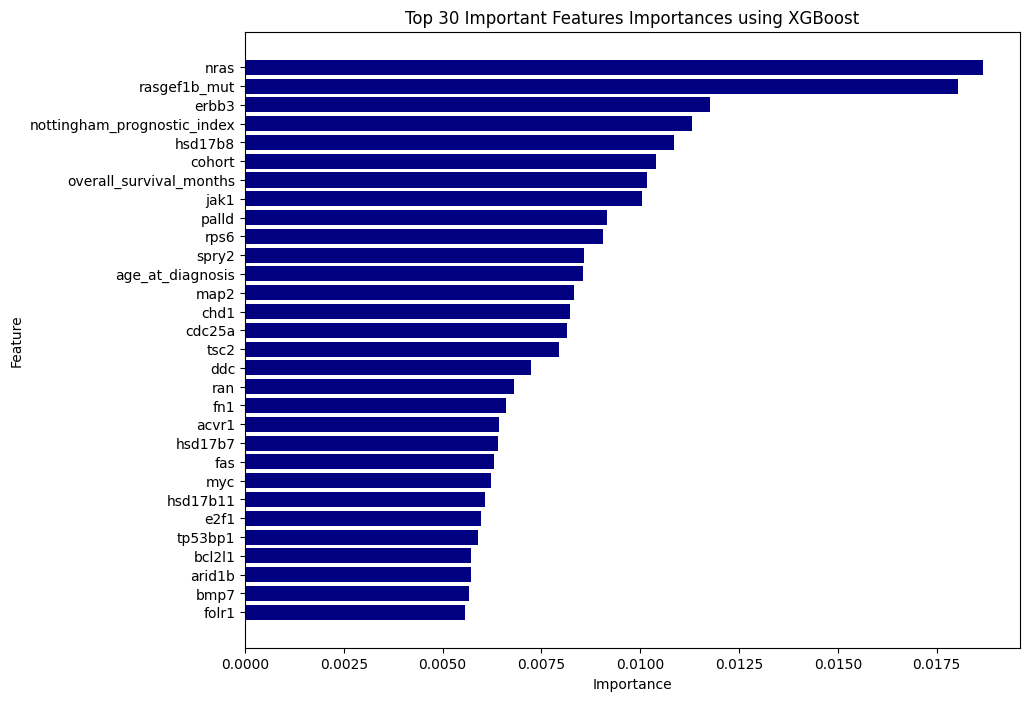

In [51]:
plt.figure(figsize=(10, 8))
plt.barh(
    feature_importance_df_xgb["feature"][:30],
    feature_importance_df_xgb["importance"][:30],
    color="navy",
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 30 Important Features Importances using XGBoost")
plt.gca().invert_yaxis()
plt.show()

### 4.4.4 Train `XGBoostClassifier` Model on the Selected Features

#### 4.4.4.1 Select the Features

In [135]:
selected_features = feature_importance_df_xgb["feature"][:12]
X_selected = X[selected_features]
X_selected.head()

,nras,rasgef1b_mut,erbb3,nottingham_prognostic_index,hsd17b8,cohort,overall_survival_months,jak1,palld,rps6,spry2,age_at_diagnosis
0,-0.3113,1,-1.7207,6.044,0.5445,1.0,140.500000,1.1097,0.1345,0.8191,2.8796,75.65
1,1.1293,1,0.5803,4.020,-2.9847,1.0,84.633333,0.9804,1.0493,1.4198,0.2446,43.19
2,1.7783,1,-1.3607,4.030,-0.9910,1.0,163.700000,1.5835,1.8646,1.3971,0.4593,48.87
3,0.5188,1,-0.6405,4.050,1.4208,1.0,164.933333,0.6194,1.1317,1.6454,1.3361,47.68
4,0.9580,1,1.4865,6.080,0.7040,1.0,41.366667,0.0461,-0.7848,-1.3988,-0.3201,76.97


#### 4.4.4.2 Split the Data to Training and Testing

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2)

#### 4.4.4.3 Apply `MinMaxScaler`

In [137]:
scaler = MinMaxScaler()
X_train_selected = pd.DataFrame(scaler.fit_transform(X_train), columns=X_selected.columns)
X_test_selected = scaler.transform(X_test)
X_train_selected

,nras,rasgef1b_mut,erbb3,nottingham_prognostic_index,hsd17b8,cohort,overall_survival_months,jak1,palld,rps6,spry2,age_at_diagnosis
0,0.722393,0.0,0.643846,0.814179,0.145249,0.75,0.414321,0.502559,0.537687,0.775068,0.706869,0.097564
1,0.324807,1.0,0.863740,0.567164,0.609987,0.25,0.320477,0.535756,0.749074,0.672618,0.361237,0.556331
2,0.252569,1.0,0.845286,0.752239,0.733980,0.00,0.102947,0.525975,0.565396,0.525528,0.178532,0.918388
3,0.677584,0.0,0.644746,0.578358,0.151543,0.50,0.062312,0.656748,0.563879,0.469586,0.404158,0.671129
4,0.363076,0.0,0.602148,0.565672,0.549839,0.50,0.604730,0.568277,0.561393,0.750283,0.331908,0.566871
...,...,...,...,...,...,...,...,...,...,...,...,...
1518,0.220704,0.0,0.659404,0.955224,0.308474,0.75,0.255631,0.263958,0.588338,0.386151,0.104636,0.517590
1519,0.540016,1.0,0.470717,0.568657,0.251785,0.00,0.203453,0.615785,0.722249,0.450276,0.381162,0.498932
1520,0.471411,0.0,0.580281,0.947015,0.334066,0.75,0.250094,0.536389,0.557785,0.659254,0.400338,0.385842
1521,0.295183,0.0,0.795928,0.376866,0.426336,0.50,0.553303,0.529299,0.849313,0.731636,0.377092,0.351090


#### 4.4.4.4 Train and Evalaute the Model before Hyperparameter Tuning

In [138]:
xgb = XGBClassifier()
xgb.fit(X_train_selected, y_train)

y_pred = xgb.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
cls_report = classification_report(y_test, y_pred)

print(f"Accuracy before hyperparameter tuning: {accuracy}\n")
print(f"Classification report before hyperparameter tuning: \n{cls_report}")

Accuracy before hyperparameter tuning: 0.7611548556430446

Classification report before hyperparameter tuning: 
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       206
           1       0.77      0.68      0.72       175

    accuracy                           0.76       381
   macro avg       0.76      0.76      0.76       381
weighted avg       0.76      0.76      0.76       381



#### 4.4.4.5 Train and Evaluate the Model after Hyperparameter Tuning

In [140]:
# Define the hyperparameters space
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.1, 0.2]
}

xgb = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy')

In [142]:
# Best model
best_model = grid_search.best_estimator_

# Best score
best_score = grid_search.best_score_
print(f"Best score: {best_score}")

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best score: 0.7826617773943054
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}


In [143]:
y_pred = best_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
cls_report = classification_report(y_test, y_pred)

print(f"Accuracy after hyperparameter tuning: {accuracy}\n")
print(f"Classification report after hyperparameter tuning: \n{cls_report}")

Accuracy after hyperparameter tuning: 0.7690288713910761

Classification report after hyperparameter tuning: 
              precision    recall  f1-score   support

           0       0.77      0.83      0.79       206
           1       0.77      0.70      0.74       175

    accuracy                           0.77       381
   macro avg       0.77      0.76      0.77       381
weighted avg       0.77      0.77      0.77       381



# 5.0 Saving the Best Model along with the Scaler and The Testing Data
The reason for saving the `test_cases_df` is for deployment. I added a feature to enable the use to fetch a random sample from the testing data to quickly test the model


In [144]:
# Saving the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Saving the model
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Saving the testing data for deployment purposes
test_cases_df = pd.concat([X_test, y_test], axis=1)
test_cases_df.to_csv("test_cases.csv", index=False)
test_cases_df.head()

,nras,rasgef1b_mut,erbb3,nottingham_prognostic_index,hsd17b8,cohort,overall_survival_months,jak1,palld,rps6,spry2,age_at_diagnosis,overall_survival
439,0.5079,1,-3.0603,4.010,-1.2669,1.0,17.766667,1.2460,0.1843,0.0767,0.9290,55.99,1
1759,-0.1256,0,0.8876,4.025,-0.2891,4.0,124.000000,0.1426,0.7159,0.9256,-0.1241,48.27,1
9,-0.8993,1,1.7559,3.056,0.4140,1.0,36.266667,-0.7607,-1.4536,1.2000,-0.9215,84.22,0
258,1.8077,1,-1.5145,4.054,-2.4227,1.0,60.666667,-0.4297,-2.2035,0.1585,-0.9217,56.45,1
81,-0.8240,1,-1.0709,6.104,-0.0579,1.0,47.633333,0.0317,0.7169,-0.6958,0.1535,53.75,0
